In [103]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import ast
import folium
from folium import plugins
import polyline
%matplotlib inline
width = 10
height = 10
matplotlib.rcParams['figure.figsize'] = [width, height]
gt_lat_lng = (33.777351, -84.396541)
map_lat_lng = (33.775734, -84.381476)
# import matplotlib.style
# import matplotlib as mpl
# mpl.style.use('default')


In [104]:
## Convert csv to h5 and store
# h5 reference: https://realpython.com/fast-flexible-pandas/#selecting-data-with-isin

strava_data = pd.read_csv('raw_strava_data.csv')
drive_morning = pd.read_csv('morning_commute.csv')
drive_evening = pd.read_csv('evening_commute.csv')
# Convert time to usable things
strava_data['elapsed_time'] = pd.to_timedelta(strava_data['elapsed_time'])
            
strava_data['moving_time'] = pd.to_timedelta(strava_data['moving_time'])

strava_data['start_date_local'] = pd.to_datetime(strava_data['start_date_local'])

drive_evening['elapsed_time'] = pd.to_timedelta("00:" + drive_evening['Duration'])
drive_morning['elapsted_time'] = pd.to_timedelta("00:" + drive_morning['Duration'])

drive_morning['start_date_local'] = pd.to_datetime(drive_morning['Date'] + " " + drive_morning["Leave Time"], format="%Y-%m-%d %I:%M")
drive_evening['start_date_local'] = pd.to_datetime(drive_evening['Date'] + " " + drive_evening["Leave Time"], format="%Y-%m-%d %I:%M:%S %p")


# Convert defaults meters to miles
strava_data['distance'] = strava_data['distance'] * 0.000621371

# The map dictionary is a string coming from the csv
strava_data["map"] = strava_data['map'].apply(ast.literal_eval)

# Create storage object with filename `processed_data`
data_store = pd.HDFStore('strava_data.h5')

# Put DataFrame into the object setting the key as 'preprocessed_df'
data_store['strava_data'] = strava_data
data_store['drive_morning'] = drive_morning
data_store['drive_evening'] = drive_evening
data_store.close()

C:\Users\gtcbh\Miniconda3\envs\commute_analysis\lib\site-packages\IPython\core\interactiveshell.py:2961: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block4_values] [items->['external_id', 'athlete', 'name', 'type', 'start_date', 'timezone', 'start_latlng', 'end_latlng', 'map', 'device_watts']]

  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\gtcbh\Miniconda3\envs\commute_analysis\lib\site-packages\IPython\core\interactiveshell.py:2961: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->['Date', 'Duration', 'Leave Time', 'From']]

  exec(code_obj, self.user_global_ns, self.user_ns)


In [105]:
# Access data store
strava_data_h5 = pd.HDFStore('strava_data.h5')

# Retrieve data using key
strava_data = strava_data_h5['strava_data']
drive_morning = strava_data_h5['drive_morning']
drive_evening = strava_data_h5['drive_evening']
strava_data_h5.close()

In [106]:
morning_mask = strava_data['start_date_local'].dt.hour.isin(range(7, 11))
evening_mask = strava_data['start_date_local'].dt.hour.isin(range(14, 20))
weekday_mask = strava_data['start_date_local'].dt.weekday.isin(range(0, 5))
normal_time_mask = ((strava_data['moving_time'].dt.seconds / 60) > 10) & ((strava_data['moving_time'].dt.seconds / 60) < 30)
bike_mask = strava_data['type'] == 'Ride'
distance_mask = (strava_data['distance'] > 2.8) & (strava_data['distance'] < 4.7)

In [107]:
morning_commutes = strava_data[morning_mask & weekday_mask & normal_time_mask & distance_mask]
evening_commutes = strava_data[evening_mask & weekday_mask & normal_time_mask & distance_mask]

In [108]:
def prepare_for_plotting(df):
    to_plot = df.copy()
    if 'moving_time' in to_plot.columns:
        to_plot['moving_time'] = to_plot.loc[:,'moving_time'] / pd.Timedelta(minutes=1)
    to_plot['elapsed_time'] = to_plot.loc[:,'elapsed_time'] / pd.Timedelta(minutes=1)
    return to_plot    

In [120]:
def plot_polylines(df):
    m = folium.Map(map_lat_lng, zoom_start=14)
    for (index, row) in df.iterrows():
        if (row['map']['summary_polyline']):
            pl = polyline.decode(row['map']['summary_polyline'])
            bike_path = folium.PolyLine(pl).add_to(m)
    return m

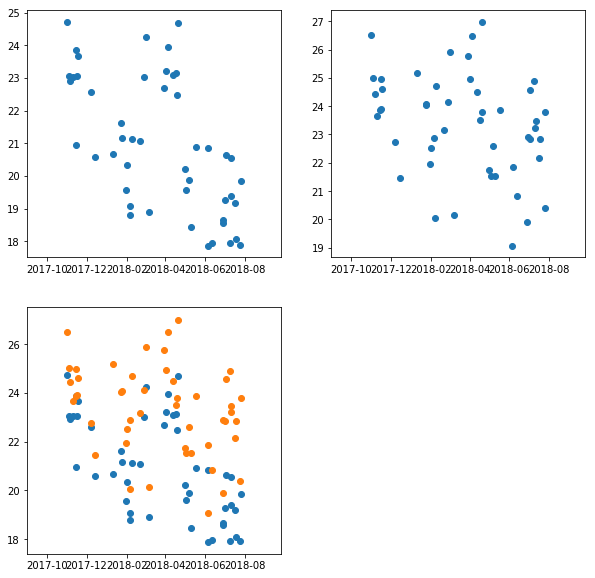

In [109]:
to_plot = prepare_for_plotting(morning_commutes)
plt.subplot(221)
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['moving_time'])
plt.subplot(222)
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['elapsed_time'])
plt.subplot(223)
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['moving_time'], color='C0')
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['elapsed_time'], color='C1')


plt.show()

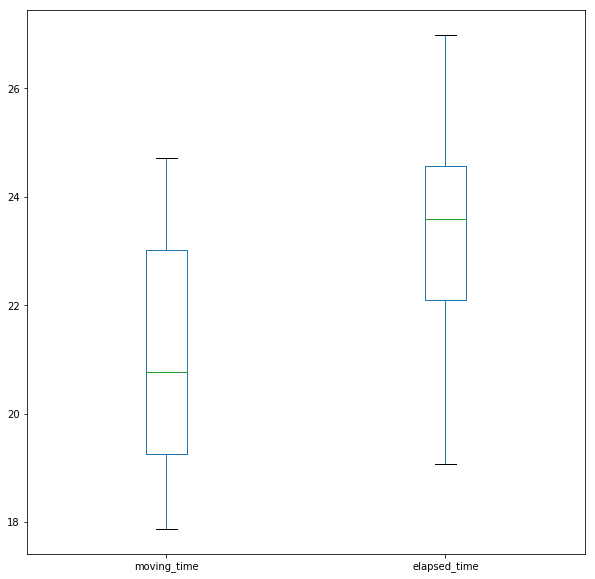

In [110]:
to_plot = prepare_for_plotting(morning_commutes)
to_plot[['moving_time', 'elapsed_time']].plot.box()
plt.show()


In [164]:
print(to_plot_car['start_date_local'].head(5))
print(to_plot['start_date_local'].head(5))

0   2018-06-07 17:06:00
1   2018-06-04 17:01:00
2   2018-05-29 17:15:00
3   2018-05-23 17:05:00
4   2018-05-22 16:44:00
Name: start_date_local, dtype: datetime64[ns]
1    2018-07-26 17:29:28
3    2018-07-25 17:09:58
7    2018-07-18 19:45:46
8    2018-07-18 17:03:22
10   2018-07-17 17:24:16
Name: start_date_local, dtype: datetime64[ns]


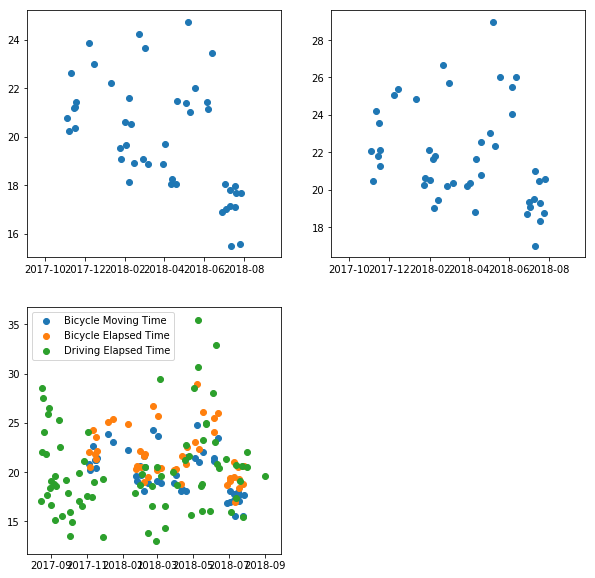

In [167]:
to_plot = prepare_for_plotting(evening_commutes)
to_plot_car = prepare_for_plotting(drive_evening.dropna())
plt.subplot(221)
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['moving_time'])
plt.subplot(222)
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['elapsed_time'])
plt.subplot(223)
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['moving_time'], color='C0')
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['elapsed_time'], color='C1')
plt.scatter(to_plot_car['start_date_local'].dt.to_pydatetime(), to_plot_car['elapsed_time'], color='C2')
plt.legend(['Bicycle Moving Time', 'Bicycle Elapsed Time', 'Driving Elapsed Time'])

plt.show()

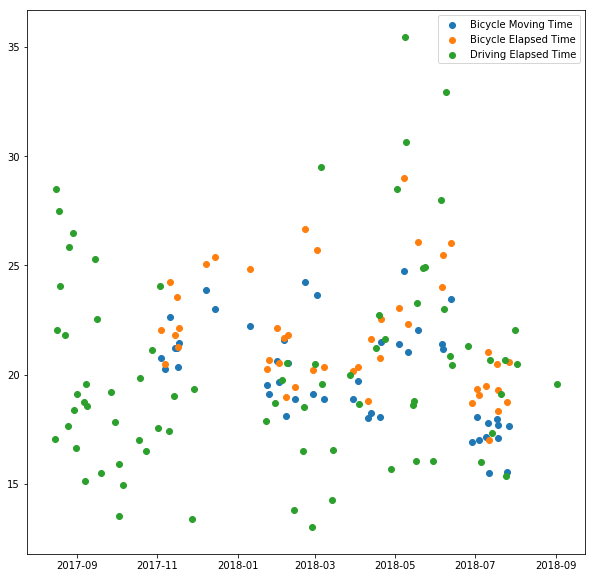

In [168]:
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['moving_time'], color='C0')
plt.scatter(to_plot['start_date_local'].dt.to_pydatetime(), to_plot['elapsed_time'], color='C1')
plt.scatter(to_plot_car['start_date_local'].dt.to_pydatetime(), to_plot_car['elapsed_time'], color='C2')
plt.legend(['Bicycle Moving Time', 'Bicycle Elapsed Time', 'Driving Elapsed Time'])

plt.show()

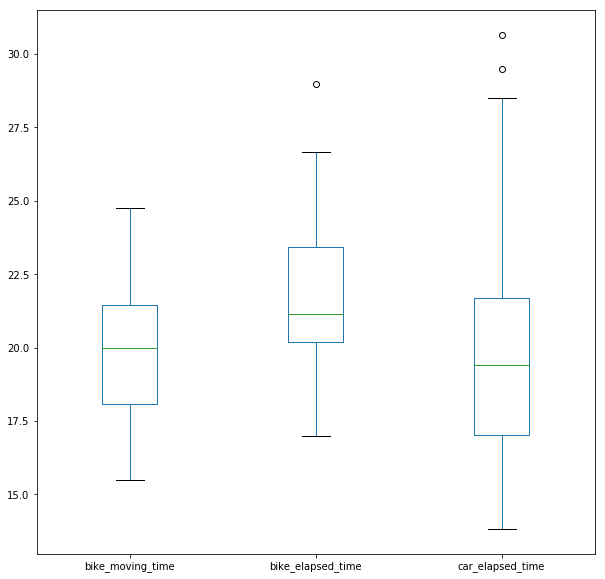

In [112]:
to_plot_bike = prepare_for_plotting(evening_commutes)
to_plot_car = prepare_for_plotting(drive_evening)
to_plot = pd.DataFrame()
to_plot['bike_moving_time'] = to_plot_bike['moving_time']
to_plot['bike_elapsed_time'] = to_plot_bike['elapsed_time']
to_plot['car_elapsed_time'] = to_plot_car['elapsed_time']

to_plot[['bike_moving_time', 'bike_elapsed_time', 'car_elapsed_time']].plot.box()
plt.show()


In [113]:
to_plot_car = prepare_for_plotting(drive_evening)
to_plot['elapsed_time'].plot.box()
plt.show()


KeyError: 'elapsed_time'

In [ ]:
pl = strava_data['map'][21]["summary_polyline"]
test = polyline.decode(pl)
test2 = list((zip(*test)))
plt.plot(test2[1], test2[0])

In [ ]:
pl = polyline.decode(strava_data['map'][21]["summary_polyline"])
m = folium.Map(map_lat_lng, zoom_start=14)
bike_path = folium.PolyLine(pl).add_to(m)
m


In [ ]:
pl = polyline.decode(strava_data['map'][21]["summary_polyline"])
m = folium.Map(map_lat_lng, zoom_start=14)
bike_path = folium.PolyLine(pl).add_to(m)

In [121]:
plot_polylines(evening_commutes)

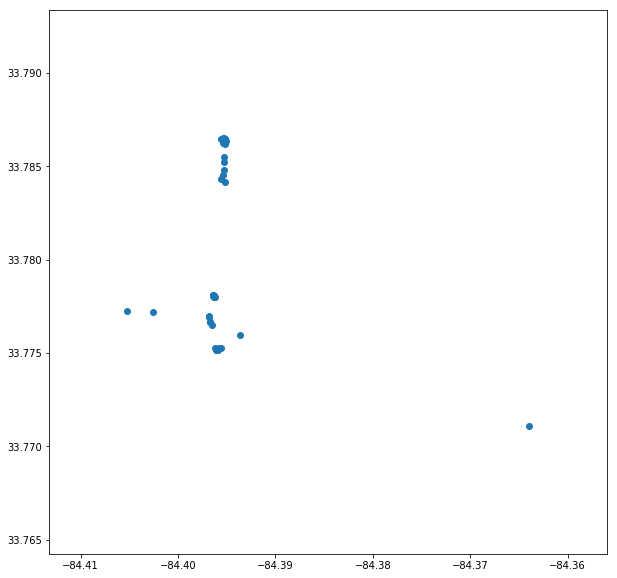

In [154]:
m = folium.Map(map_lat_lng, zoom_start=14)
end_latlng = []
for (index, row) in evening_commutes.iterrows():
    if (row['map']['summary_polyline']):
        pl = polyline.decode(row['map']['summary_polyline'])
        end_latlng.append(pl[1])
temp = list(zip(*end_latlng))
end_lat = temp[0]
end_lng = temp[1]
plt.scatter(end_lng, end_lat)

In [155]:
for point in end_latlng:
    folium.Marker(point).add_to(m)
m

In [16]:
# https://markhneedham.com/blog/2017/04/29/leaflet-strava-polylines-osm/
# https://dzone.com/articles/strava-calculating-the-similarity-of-two-runs
# http://bl.ocks.org/matt-leach/5336dc8249cf4401fc0f6b31743202e5
# http://andykee.com/visualizing-strava-tracks-with-python.html
# https://gis.stackexchange.com/questions/42224/creating-polyline-based-heatmap-from-gps-tracks
# https://yizeng.me/2017/01/11/get-a-strava-api-access-token-with-write-permission/